In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import os
import requests
import tempfile
from google.cloud import bigquery
from google.cloud import bigquery_storage_v1
from functools import partialmethod
import pymysql

In [2]:
client = bigquery.Client.from_service_account_json('./lwapps-coloring.json')
bigquery_storage_v1.client.BigQueryReadClient.read_rows = partialmethod(bigquery_storage_v1.client.BigQueryReadClient.read_rows, timeout=3600*2) 
bq_storage_client = bigquery_storage_v1.BigQueryReadClient.from_service_account_json('./lwapps-coloring.json')
project_id = 'lwapps-coloring'

In [27]:
sql = '''
select platform, operating_system_version, event_date, round(avg(session_time_minutes), 4) as avg_session_time_minutes
from (
    select platform, operating_system_version, event_date, user_id, ga_session_id, 
        timestamp_diff(max(event_timestamp), min(event_timestamp), minute) as session_time_minutes
    from (
        SELECT platform, device.operating_system_version,	PARSE_DATE('%Y%m%d',  event_date) as event_date, 
            user_id, timestamp_micros(event_timestamp) as event_timestamp, 
            param.value.int_value as ga_session_id
        FROM `lwapps-coloring.analytics_218793363.events_*`, 
        unnest(event_params) as param
        where  (_TABLE_SUFFIX between '20210401' and '20210410') 
            and user_id is not null 
            and param.key = 'ga_session_id'
            and lower(geo.country) != 'belarus')
    group by platform, operating_system_version, event_date, user_id, ga_session_id)  
group by  platform, operating_system_version, event_date
order by  platform,	operating_system_version     
'''
session_time = client.query(sql, project=project_id).to_dataframe()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FEAEA977C0>]],
      dtype=object)

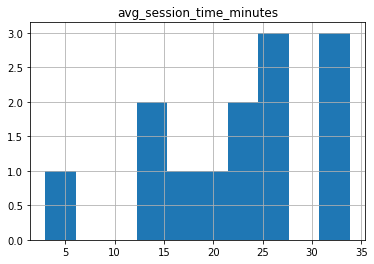

In [28]:
session_time[(session_time.platform=='ANDROID') & 
             (session_time.event_date==dt.date(2021,4,1))].hist("avg_session_time_minutes")

In [29]:
SD = np.std(session_time[(session_time.platform=='ANDROID') & 
             (session_time.event_date==dt.date(2021,4,1))].avg_session_time_minutes)
median = np.median(session_time[(session_time.platform=='ANDROID') & 
             (session_time.event_date==dt.date(2021,4,1))].avg_session_time_minutes)

In [30]:
session_time[(session_time.platform=='ANDROID') & 
             (session_time.event_date==dt.date(2021,4,1)) & 
             (session_time.avg_session_time_minutes<=median-2*SD)]

platform operating_system_version  event_date  avg_session_time_minutes
17  ANDROID             Android 10.0  2021-04-01                       3.0

In [31]:
SD_ios = np.std(session_time[(session_time.platform=='IOS') & 
             (session_time.event_date==dt.date(2021,4,1))].avg_session_time_minutes)
median_ios = np.median(session_time[(session_time.platform=='IOS') & 
             (session_time.event_date==dt.date(2021,4,1))].avg_session_time_minutes)

In [32]:
session_time[(session_time.platform=='IOS') & 
             (session_time.event_date==dt.date(2021,4,1)) & 
             (session_time.avg_session_time_minutes<=median_ios-2*SD_ios)]

Empty DataFrame
Columns: [platform, operating_system_version, event_date, avg_session_time_minutes]
Index: []

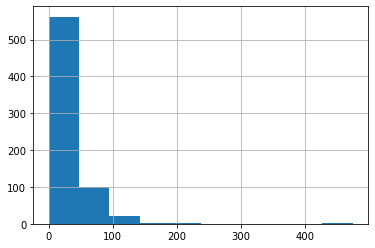

In [36]:
session_time[(session_time.platform=='IOS')].avg_session_time_minutes.hist()

In [37]:
session_time[(session_time.platform=='IOS') & 
            (session_time.avg_session_time_minutes<=5)]

platform operating_system_version  event_date  avg_session_time_minutes
139      IOS               iOS 10.0.1  2021-04-10                    3.0000
142      IOS               iOS 10.0.1  2021-04-09                    0.0000
171      IOS                 iOS 10.2  2021-04-01                    0.0000
172      IOS                 iOS 10.2  2021-04-07                    5.0000
179      IOS               iOS 10.2.1  2021-04-04                    3.0000
180      IOS               iOS 10.2.1  2021-04-08                    2.0000
184      IOS               iOS 10.3.1  2021-04-09                    2.0000
212      IOS                 iOS 11.0  2021-04-02                    2.0000
225      IOS               iOS 11.0.1  2021-04-05                    2.0000
227      IOS               iOS 11.0.3  2021-04-06                    4.0000
228      IOS               iOS 11.0.3  2021-04-01                    2.0000
229      IOS               iOS 11.0.3  2021-04-03                    1.0000
236      IOS               iOS 11.1.1  2021-04-01                    1.0000
240      IOS               iOS 11.1.1  2021-04-06                    0.0000
241      IOS               iOS 11.1.1  2021-04-09                    0.0000
257      IOS                 iOS 11.2  2021-04-04                    0.0000
275      IOS               iOS 11.2.2  2021-04-10                    0.5000
277      IOS               iOS 11.2.2  2021-04-08                    1.6667
309      IOS                 iOS 11.3  2021-04-08                    0.0000
352      IOS               iOS 12.0.1  2021-04-01                    3.4286
359      IOS               iOS 12.0.1  2021-04-09                    5.0000
386      IOS               iOS 12.1.2  2021-04-09                    1.0000
389      IOS               iOS 12.1.2  2021-04-08                    0.0000
396      IOS               iOS 12.1.3  2021-04-06                    1.5000
424      IOS                 iOS 12.3  2021-04-02                    3.6667
449      IOS               iOS 12.3.2  2021-04-04                    4.7500
470      IOS               iOS 12.4.2  2021-04-04                    1.0000
471      IOS               iOS 12.4.2  2021-04-01                    5.0000
472      IOS               iOS 12.4.2  2021-04-02                    0.0000
476      IOS               iOS 12.4.4  2021-04-02                    3.6000
477      IOS               iOS 12.4.4  2021-04-07                    1.0000
478      IOS               iOS 12.4.4  2021-04-03                    1.2500
479      IOS               iOS 12.4.4  2021-04-04                    0.0000
480      IOS               iOS 12.4.4  2021-04-06                    4.0000
481      IOS               iOS 12.4.4  2021-04-09                    0.3333
482      IOS               iOS 12.4.4  2021-04-08                    5.0000
487      IOS               iOS 12.4.5  2021-04-09                    0.0000
489      IOS               iOS 12.4.5  2021-04-02                    1.0000
491      IOS               iOS 12.4.5  2021-04-07                    0.0000
492      IOS               iOS 12.4.6  2021-04-03                    1.0000
493      IOS               iOS 12.4.6  2021-04-10                    4.0000
494      IOS               iOS 12.4.6  2021-04-07                    0.0000
495      IOS               iOS 12.4.6  2021-04-06                    4.0000
497      IOS               iOS 12.4.7  2021-04-05                    1.0000
498      IOS               iOS 12.4.7  2021-04-03                    3.0000
499      IOS               iOS 12.4.7  2021-04-01                    5.0000
500      IOS               iOS 12.4.8  2021-04-04                    2.3333
502      IOS               iOS 12.4.8  2021-04-03                    3.0909
507      IOS               iOS 12.4.8  2021-04-06                    1.5556
517      IOS               iOS 12.4.9  2021-04-08                    1.2222
519      IOS               iOS 12.4.9  2021-04-09                    2.8750
522      IOS                 iOS 12.5  2021-04-08   

In [38]:
sql = '''
select platform, mobile_brand_name, mobile_model_name, event_date, round(avg(session_time_minutes), 4) as avg_session_time_minutes
from (
    select platform, mobile_brand_name,mobile_model_name, event_date, user_id, ga_session_id, 
        timestamp_diff(max(event_timestamp), min(event_timestamp), second) as session_time_minutes
    from (
        SELECT platform, device.mobile_brand_name,	device.mobile_model_name, PARSE_DATE('%Y%m%d',  event_date) as event_date, 
            user_id, timestamp_micros(event_timestamp) as event_timestamp, 
            param.value.int_value as ga_session_id
        FROM `lwapps-coloring.analytics_218793363.events_*`, 
        unnest(event_params) as param
        where  (_TABLE_SUFFIX between '20210401' and '20210410') 
            and user_id is not null 
            and param.key = 'ga_session_id'
            and lower(geo.country) != 'belarus'
            and device.mobile_brand_name is not null 
            and device.mobile_model_name is not null)
    group by platform, mobile_brand_name,mobile_model_name, event_date, user_id, ga_session_id)  
group by  platform, mobile_brand_name,mobile_model_name, event_date
order by  platform, mobile_brand_name,mobile_model_name
'''
devices = client.query(sql, project=project_id).to_dataframe()

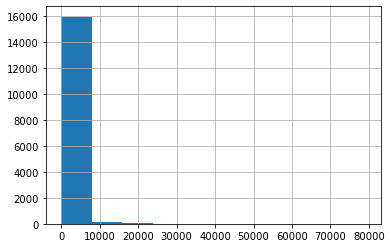

In [40]:
devices.avg_session_time_minutes.hist()

In [42]:
np.mean(devices.avg_session_time_minutes)/60

28.8392945063516

In [44]:
np.var(devices.avg_session_time_minutes)

7282835.957759355

In [45]:
sql = '''
select platform, mobile_brand_name, mobile_model_name, round(avg(session_time_minutes), 4) as avg_session_time_minutes
from (
    select platform, mobile_brand_name,mobile_model_name, user_id, ga_session_id, 
        timestamp_diff(max(event_timestamp), min(event_timestamp), second) as session_time_minutes
    from (
        SELECT platform, device.mobile_brand_name,	device.mobile_model_name, 
            user_id, timestamp_micros(event_timestamp) as event_timestamp, 
            param.value.int_value as ga_session_id
        FROM `lwapps-coloring.analytics_218793363.events_*`, 
        unnest(event_params) as param
        where  (_TABLE_SUFFIX between '20210401' and '20210410') 
            and user_id is not null 
            and param.key = 'ga_session_id'
            and lower(geo.country) != 'belarus'
            and device.mobile_brand_name is not null 
            and device.mobile_model_name is not null)
    group by platform, mobile_brand_name,mobile_model_name, user_id, ga_session_id)  
group by  platform, mobile_brand_name,mobile_model_name
order by  platform, mobile_brand_name,mobile_model_name
'''
devices = client.query(sql, project=project_id).to_dataframe()
devices.rename(columns={"avg_session_time_minutes": "avg_session_time_sec"}, inplace=True)

In [51]:
devices['avg_session_time_min'] = devices['avg_session_time_sec']/60

In [52]:
np.mean(devices.avg_session_time_min)

106.54950381884323

In [53]:
np.std(devices.avg_session_time_min)

401.3669901315159

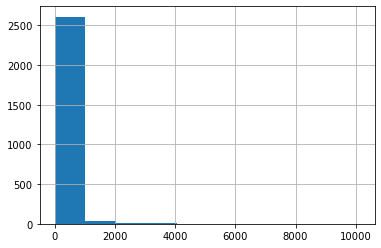

In [55]:
devices.avg_session_time_min.hist()

### Ретенш разных устройств

In [ ]:
with registrations as (
    select platform, device_type, appsflyer_id, date(min(event_time)) as registration_date 
    from `goingtoclouds.appsflyer_happy_canvas.appsflyer_registration`
    where install_date between '2021-01-01' and '2021-04-07'
    group by platform, device_type, appsflyer_id), 

launches as (
    select platform, device_type, appsflyer_id, event_date 
    from `goingtoclouds.appsflyer_happy_canvas.appsflyer_launch`
    where event_date between '2021-01-01' and '2021-04-10'    
), 

joint_data as (
    select registrations.platform, registrations.device_type, registrations.appsflyer_id, 
    registration_date, date_diff(event_date, registration_date, day) as cohort_day, event_date 
    from registrations 
    left join launches
    on registrations.platform=launches.platform
    and registrations.device_type=launches.device_type
    and registrations.appsflyer_id=launches.appsflyer_id

)

SELECT platform, device_type, registration_date, total_users, 
    AVG(IF(cohort_day=1, retention_rate, null)) as day_1,
    AVG(IF(cohort_day=3, retention_rate, null)) as day_3,
    AVG(IF(cohort_day=7, retention_rate, null)) as day_7,
    AVG(IF(cohort_day=14, retention_rate, null)) as day_14,
    AVG(IF(cohort_day=30, retention_rate, null)) as day_30,
    AVG(IF(cohort_day=60, retention_rate, null)) as day_60,
    AVG(IF(cohort_day=60, retention_rate, null)) as day_90
    
from (
    select a.platform, a.device_type, a.registration_date, cohort_day, total_users, 
        returned_users, round(returned_users/total_users, 5) as retention_rate
    from (
        select platform, device_type, registration_date, count(distinct appsflyer_id) as total_users
        from joint_data
        group by  platform, device_type, registration_date) as a
    left join (
        select platform, device_type, registration_date, cohort_day, count(distinct appsflyer_id) as returned_users
        from joint_data
        group by  platform, device_type, registration_date, cohort_day
    ) as b
    on a.platform=b.platform
    and a.device_type=b.device_type
    and a.registration_date=b.registration_date
    where cohort_day is not null and cohort_day >=0
    order by a.platform, a.registration_date, cohort_day
)
group by platform, device_type, registration_date, total_users
order by platform, device_type, registration_date


Проверяем гипотезу о длине сессии у старых и новых пользователей

до загрузки фида (без фида)
с фидом, но без кора
с кором (кнопка старт на прилаунче или первый шейп)